# GSTORE CUSTOMER REVENUE PREDICTION - DATA CLEANING and MODEL BUILDING
***By HARISH JULAPALLI***

**Importing required libraries:**

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import json


%matplotlib inline
plt.style.use('ggplot')

import os
print(os.listdir("../input"))

['train_v2.csv', 'test_v2.csv', 'sample_submission_v2.csv']


**Data Loading:**

In [3]:
def load_df(csv_path='../input/train_v2.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}_{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df
        

In [4]:
train_df = load_df(nrows = 200000)

Loaded train_v2.csv. Shape: (200000, 60)


In [5]:
train_df.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device_browser,device_browserSize,device_browserVersion,device_deviceCategory,device_flashVersion,device_isMobile,device_language,device_mobileDeviceBranding,device_mobileDeviceInfo,device_mobileDeviceMarketingName,device_mobileDeviceModel,device_mobileInputSelector,device_operatingSystem,device_operatingSystemVersion,device_screenColors,device_screenResolution,geoNetwork_city,geoNetwork_cityId,geoNetwork_continent,geoNetwork_country,geoNetwork_latitude,geoNetwork_longitude,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_networkLocation,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.criteriaParameters,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_campaignCode,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,3162355547410993243,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,water bottle,organic,NaN,google
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,8934116514970143966,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,not available in demo dataset,not available in demo dataset,Cupertino,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,San Francisco-Oakland-San Jose CA,(not set),not available in demo dataset,California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,7992466427990357681,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,mobile,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,not available in demo 

In [6]:
test_df = load_df(csv_path='../input/test_v2.csv', nrows=50000)

Loaded test_v2.csv. Shape: (50000, 59)


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 60 columns):
channelGrouping                                      200000 non-null object
customDimensions                                     200000 non-null object
date                                                 200000 non-null int64
fullVisitorId                                        200000 non-null object
hits                                                 200000 non-null object
socialEngagementType                                 200000 non-null object
visitId                                              200000 non-null int64
visitNumber                                          200000 non-null int64
visitStartTime                                       200000 non-null int64
device_browser                                       200000 non-null object
device_browserSize                                   200000 non-null object
device_browserVersion                                2000

**Removing single category columns:**

In [8]:
single_cat_cols_train = [col for col in train_df.columns if train_df.nunique()[col] == 1]
train_df.drop(single_cat_cols_train, axis = 1, inplace = True)

In [9]:
single_cat_cols_test = [col for col in test_df.columns if test_df.nunique()[col] == 1]
test_df.drop(single_cat_cols_test, axis = 1, inplace = True)

In [10]:
list(set(test_df.columns) - set(train_df.columns))

[]

**Removing columns: 'customDimensions','hits','trafficSource_adwordsClickInfo.page', as they don't add any meaning.**

In [11]:
train_df.drop(['customDimensions','hits','trafficSource_adwordsClickInfo.page'], axis = 1, inplace = True)
test_df.drop(['customDimensions','hits'], axis = 1, inplace = True)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 33 columns):
channelGrouping                                 200000 non-null object
date                                            200000 non-null int64
fullVisitorId                                   200000 non-null object
visitId                                         200000 non-null int64
visitNumber                                     200000 non-null int64
visitStartTime                                  200000 non-null int64
device_browser                                  200000 non-null object
device_deviceCategory                           200000 non-null object
device_isMobile                                 200000 non-null bool
device_operatingSystem                          200000 non-null object
geoNetwork_city                                 200000 non-null object
geoNetwork_continent                            200000 non-null object
geoNetwork_country                         

**Converting numeric columns from 'Object' to 'float':**

In [13]:
numeric_cols = [col for col in train_df.columns if 'totals_' in col]
print(numeric_cols)

['totals_hits', 'totals_pageviews', 'totals_sessionQualityDim', 'totals_timeOnSite', 'totals_totalTransactionRevenue', 'totals_transactionRevenue', 'totals_transactions']


In [14]:
train_df[numeric_cols] = train_df[numeric_cols].astype('float64')
test_df[numeric_cols] = test_df[numeric_cols].astype('float64')

**visitStartTime** column has UNIX time, which gives us time attribute to. So, retaining it and removing 'Date' column.

In [15]:
train_df['visitStartTime'] = pd.to_datetime(train_df['visitStartTime'], unit = 's')
test_df['visitStartTime'] = pd.to_datetime(test_df['visitStartTime'], unit = 's')

In [16]:
train_df.drop('date', axis = 1, inplace = True)
test_df.drop('date', axis = 1, inplace = True)

In [17]:
train_df['visitId'] = train_df['visitId'].astype('object')
test_df['visitId'] = test_df['visitId'].astype('object')

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 32 columns):
channelGrouping                                 200000 non-null object
fullVisitorId                                   200000 non-null object
visitId                                         200000 non-null object
visitNumber                                     200000 non-null int64
visitStartTime                                  200000 non-null datetime64[ns]
device_browser                                  200000 non-null object
device_deviceCategory                           200000 non-null object
device_isMobile                                 200000 non-null bool
device_operatingSystem                          200000 non-null object
geoNetwork_city                                 200000 non-null object
geoNetwork_continent                            200000 non-null object
geoNetwork_country                              200000 non-null object
geoNetwork_metro                

**Extracting Time features:**

In [19]:
train_df = train_df.set_index('visitStartTime')

In [20]:
train_df['day'] = train_df.index.day
train_df['month'] = train_df.index.month
train_df['day_of_week'] = train_df.index.dayofweek
train_df['hour'] = train_df.index.hour

In [21]:
test_df = test_df.set_index('visitStartTime')
test_df['day'] = test_df.index.day
test_df['month'] = test_df.index.month
test_df['day_of_week'] = test_df.index.dayofweek
test_df['hour'] = test_df.index.hour

In [22]:
train_df = train_df.reset_index()
test_df = test_df.reset_index()
train_df.head()

,visitStartTime,channelGrouping,fullVisitorId,visitId,visitNumber,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_hits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,day,month,day_of_week,hour
0,2017-10-17 00:00:50,Organic Search,3162355547410993243,1508198450,1,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),water bottle,organic,NaN,google,17,10,1,0
1,2017-10-16 17:51:47,Referral,8934116514970143966,1508176307,6,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,2.0,2.0,2.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,16,10,0,17
2,2017-10-17 00:53:33,Direct,7992466427990357681,1508201613,1,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,2.0,2.0,1.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(none),NaN,(direct),17,10,1,0
3,2017-10-16 16:04:11,Organic Search,9075655783635761930,1508169851,1,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,2.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,16,10,0,16
4,2017-10-16 21:49:12,Organic Search,6960673291025684308,1508190552,1,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,2.0,2.0,1.0,52.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,16,10,0,21


**Missing values treatment:**

*Percantage of missing values per each column:*

In [23]:
(train_df.isna().sum()/train_df.shape[0])*100

visitStartTime                                   0.0000
channelGrouping                                  0.0000
fullVisitorId                                    0.0000
visitId                                          0.0000
visitNumber                                      0.0000
device_browser                                   0.0000
device_deviceCategory                            0.0000
device_isMobile                                  0.0000
device_operatingSystem                           0.0000
geoNetwork_city                                  0.0000
geoNetwork_continent                             0.0000
geoNetwork_country                               0.0000
geoNetwork_metro                                 0.0000
geoNetwork_networkDomain                         0.0000
geoNetwork_region                                0.0000
geoNetwork_subContinent                          0.0000
totals_hits                                      0.0000
totals_pageviews                                

*Filling missing values in numeric columns with '0':*

In [24]:
numeric_cols

['totals_hits',
 'totals_pageviews',
 'totals_sessionQualityDim',
 'totals_timeOnSite',
 'totals_totalTransactionRevenue',
 'totals_transactionRevenue',
 'totals_transactions']

In [25]:
train_df[numeric_cols] = train_df[numeric_cols].fillna(0)

In [26]:
test_df[numeric_cols] = test_df[numeric_cols].fillna(0)

Although categorical columns seesms to have no missing values, there are many rows with values like, **(not set)** and **not available in demo dataset** to **unknown**.

In [27]:
cat_cols = [col for col in train_df.columns if train_df[col].dtype == 'object']
cat_cols.remove('fullVisitorId')
cat_cols.remove('visitId')
print(cat_cols)

['channelGrouping', 'device_browser', 'device_deviceCategory', 'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent', 'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId', 'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_keyword', 'trafficSource_medium', 'trafficSource_referralPath', 'trafficSource_source']


In [28]:
for col in cat_cols:
    train_df[col] = train_df[col].str.replace('^\(.*', 'unknown', regex = True)
    train_df[col] = train_df[col].str.replace('not available in demo dataset', 'unknown', regex = False)

In [29]:
for col in cat_cols:
    test_df[col] = test_df[col].str.replace('^\(.*', 'unknown', regex = True)
    test_df[col] = test_df[col].str.replace('not available in demo dataset', 'unknown', regex = False)

In [30]:
(train_df.isna().sum()/train_df.shape[0])*100

visitStartTime                                   0.0000
channelGrouping                                  0.0000
fullVisitorId                                    0.0000
visitId                                          0.0000
visitNumber                                      0.0000
device_browser                                   0.0000
device_deviceCategory                            0.0000
device_isMobile                                  0.0000
device_operatingSystem                           0.0000
geoNetwork_city                                  0.0000
geoNetwork_continent                             0.0000
geoNetwork_country                               0.0000
geoNetwork_metro                                 0.0000
geoNetwork_networkDomain                         0.0000
geoNetwork_region                                0.0000
geoNetwork_subContinent                          0.0000
totals_hits                                      0.0000
totals_pageviews                                

*trafficSource_adwordsClickInfo.gclId is the ID for each click a user performs on the site. So, it can be removed as it does not add any value to our analysis*

In [31]:
train_df.drop('trafficSource_adwordsClickInfo.gclId', axis = 1, inplace = True)
test_df.drop('trafficSource_adwordsClickInfo.gclId', axis = 1, inplace = True)

*Filling missing values in Traffic source columns with 'unknown', as more than 50% of values are missing and we can't just impute them.*

In [32]:
traffic_source_cols = [col for col in train_df.columns if 'trafficSource_' in col]
traffic_source_cols.remove('trafficSource_campaign')
traffic_source_cols.remove('trafficSource_medium')
traffic_source_cols

['trafficSource_adContent',
 'trafficSource_adwordsClickInfo.adNetworkType',
 'trafficSource_adwordsClickInfo.slot',
 'trafficSource_keyword',
 'trafficSource_referralPath',
 'trafficSource_source']

In [33]:
for col in traffic_source_cols:
    train_df[col].fillna('unknown', inplace = True)
    test_df[col].fillna('unknown', inplace = True)

*There are many categories in traffic_source column with 'google', 'youtube', 'bing' etc. but with different kinds of strings containing the words. So, we can replace them with main category. Below function does the same.*

In [34]:
def add_new_category(x):
    x = str(x).lower()
    if 'google' in x:
        return 'google'
    elif 'baidu' in x:
        return 'baidu'
    elif 'facebook' in x:
        return 'facebook'
    elif 'reddit' in x:
        return 'reddit'
    elif 'yahoo' in x:
        return 'yahoo'
    elif 'bing' in x:
        return 'bing'
    elif 'yandex' in x:
        return 'yandex'
    else:
        return 'other'

In [35]:
train_df['trafficSource_source'] = train_df['trafficSource_source'].apply(add_new_category)
test_df['trafficSource_source'] = test_df['trafficSource_source'].apply(add_new_category)

*Similarly replacing strings in 'trafficSource_keyword' column with main keyword with the help of below function:*

In [36]:
def add_new_category(x):
    x = str(x).lower()
    if x == 'nan':
        return 'nan'
    
    x = ''.join(x.split())
    
    if 'youtube' in x or 'you' in x or 'yo' in x or 'tub' in x:
        return 'youtube'
    elif 'google' in x or 'goo' in x or 'gle' in x:
        return 'google'
    else:
        return 'other'

In [37]:
train_df['trafficSource_keyword'] = train_df['trafficSource_keyword'].apply(add_new_category)
test_df['trafficSource_keyword'] = test_df['trafficSource_keyword'].apply(add_new_category)

In [38]:
(train_df.isna().sum()/train_df.shape[0])*100

visitStartTime                                  0.0
channelGrouping                                 0.0
fullVisitorId                                   0.0
visitId                                         0.0
visitNumber                                     0.0
device_browser                                  0.0
device_deviceCategory                           0.0
device_isMobile                                 0.0
device_operatingSystem                          0.0
geoNetwork_city                                 0.0
geoNetwork_continent                            0.0
geoNetwork_country                              0.0
geoNetwork_metro                                0.0
geoNetwork_networkDomain                        0.0
geoNetwork_region                               0.0
geoNetwork_subContinent                         0.0
totals_hits                                     0.0
totals_pageviews                                0.0
totals_sessionQualityDim                        0.0
totals_timeO

***So, we have dealt with all the missing values.***

**Feature Engineering:**

Adding columns like **mean hits per network domain** and **mean page views per network domain**, as hits and pageviews are very important in knowing wether a transaction happens or not. For example, if a user made many hits, it can mean that, he is going through various pages/photos/reviews of a product and has some interest in it, and this can be directly translated to revenue.

In [39]:
train_df['mean_hits_per_networkDomain'] = train_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean').astype('int')
train_df['mean_pageViews_per_networkDomain'] = train_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean').astype('int')

In [40]:
test_df['mean_hits_per_networkDomain'] = test_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean').astype('int')
test_df['mean_pageViews_per_networkDomain'] = test_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean').astype('int')

In [41]:
train_df.head()

,visitStartTime,channelGrouping,fullVisitorId,visitId,visitNumber,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_hits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,day,month,day_of_week,hour,mean_hits_per_networkDomain,mean_pageViews_per_networkDomain
0,2017-10-17 00:00:50,Organic Search,3162355547410993243,1508198450,1,Firefox,desktop,False,Windows,unknown,Europe,Germany,unknown,unknown,unknown,Western Europe,1.0,1.0,1.0,0.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,organic,unknown,google,17,10,1,0,5,4
1,2017-10-16 17:51:47,Referral,8934116514970143966,1508176307,6,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,unknown,California,Northern America,2.0,2.0,2.0,28.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,referral,/a/google.com/transportation/mtv-services/bike...,google,16,10,0,17,5,4
2,2017-10-17 00:53:33,Direct,7992466427990357681,1508201613,1,Chrome,mobile,True,Android,unknown,Americas,United States,unknown,windjammercable.net,unknown,Northern America,2.0,2.0,1.0,38.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,unknown,unknown,other,17,10,1,0,1,1
3,2017-10-16 16:04:11,Organic Search,9075655783635761930,1508169851,1,Chrome,desktop,False,Windows,unknown,Asia,Turkey,unknown,unknown.unknown,unknown,Western Asia,2.0,2.0,1.0,1.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,organic,unknown,google,16,10,0,16,3,2
4,2017-10-16 21:49:12,Organic Search,6960673291025684308,1508190552,1,Chrome,desktop,False,Windows,unknown,Americas,Mexico,unknown,prod-infinitum.com.mx,unknown,Central America,2.0,2.0,1.0,52.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,organic,unknown,google,16,10,0,21,2,2


In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 37 columns):
visitStartTime                                  200000 non-null datetime64[ns]
channelGrouping                                 200000 non-null object
fullVisitorId                                   200000 non-null object
visitId                                         200000 non-null object
visitNumber                                     200000 non-null int64
device_browser                                  200000 non-null object
device_deviceCategory                           200000 non-null object
device_isMobile                                 200000 non-null bool
device_operatingSystem                          200000 non-null object
geoNetwork_city                                 200000 non-null object
geoNetwork_continent                            200000 non-null object
geoNetwork_country                              200000 non-null object
geoNetwork_metro                

Dropping columns like 'fullVisitorId', 'visitId', 'visitStartTime' as they offer nothing to our predictions and I have already extarcted features from 'visitStartTime' column like 'day', 'month','hour' etc. 

In [43]:
train_fullVisitorId = train_df['fullVisitorId']
train_visitId = train_df['visitId']
train_date = train_df['visitStartTime']

test_fullVisitorId = test_df['fullVisitorId']
test_visitId = test_df['visitId']
test_date = test_df['visitStartTime']

train_df.drop(['fullVisitorId', 'visitId','visitStartTime'], axis=1, inplace=True)
test_df.drop(['fullVisitorId', 'visitId','visitStartTime'], axis=1, inplace=True)

In [44]:
train_df.head()

,channelGrouping,visitNumber,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_hits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,day,month,day_of_week,hour,mean_hits_per_networkDomain,mean_pageViews_per_networkDomain
0,Organic Search,1,Firefox,desktop,False,Windows,unknown,Europe,Germany,unknown,unknown,unknown,Western Europe,1.0,1.0,1.0,0.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,organic,unknown,google,17,10,1,0,5,4
1,Referral,6,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,unknown,California,Northern America,2.0,2.0,2.0,28.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,referral,/a/google.com/transportation/mtv-services/bike...,google,16,10,0,17,5,4
2,Direct,1,Chrome,mobile,True,Android,unknown,Americas,United States,unknown,windjammercable.net,unknown,Northern America,2.0,2.0,1.0,38.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,unknown,unknown,other,17,10,1,0,1,1
3,Organic Search,1,Chrome,desktop,False,Windows,unknown,Asia,Turkey,unknown,unknown.unknown,unknown,Western Asia,2.0,2.0,1.0,1.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,organic,unknown,google,16,10,0,16,3,2
4,Organic Search,1,Chrome,desktop,False,Windows,unknown,Americas,Mexico,unknown,prod-infinitum.com.mx,unknown,Central America,2.0,2.0,1.0,52.0,0.0,0.0,0.0,unknown,unknown,unknown,unknown,other,organic,unknown,google,16,10,0,21,2,2


Dropping 'totals_totalTransactionRevenue' column as it has high correlation with 'totals_transactionRevenue' column which are analogus to each other by intution.

In [45]:
train_df[['totals_totalTransactionRevenue','totals_transactionRevenue']].corr()

,totals_totalTransactionRevenue,totals_transactionRevenue
totals_totalTransactionRevenue,1.000000,0.950965
totals_transactionRevenue,0.950965,1.000000


In [46]:
train_df.drop(['totals_totalTransactionRevenue'], axis=1, inplace=True)
test_df.drop(['totals_totalTransactionRevenue'], axis=1, inplace=True)

**Encoding categorical columns:**

In [47]:
cat_cols = [col for col in train_df.columns if train_df[col].dtype in ['object','bool']]

In [48]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

train_df[cat_cols] = train_df[cat_cols].apply(lb.fit_transform)
test_df[cat_cols] = test_df[cat_cols].apply(lb.fit_transform)

In [49]:
train_df.head()

,channelGrouping,visitNumber,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_hits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,day,month,day_of_week,hour,mean_hits_per_networkDomain,mean_pageViews_per_networkDomain
0,3,1,16,0,0,16,400,3,64,67,10594,275,21,1.0,1.0,1.0,0.0,0.0,0.0,48,3,3,27,1,3,1366,3,17,10,1,0,5,4
1,5,6,11,0,0,2,103,1,190,59,10594,42,11,2.0,2.0,2.0,28.0,0.0,0.0,48,3,3,27,1,4,94,3,16,10,0,17,5,4
2,1,1,11,1,1,0,400,1,190,67,11319,275,11,2.0,2.0,1.0,38.0,0.0,0.0,48,3,3,27,1,5,1366,4,17,10,1,0,1,1
3,3,1,11,0,0,16,400,2,182,67,10609,275,20,2.0,2.0,1.0,1.0,0.0,0.0,48,3,3,27,1,3,1366,3,16,10,0,16,3,2
4,3,1,11,0,0,16,400,1,118,67,7900,275,2,2.0,2.0,1.0,52.0,0.0,0.0,48,3,3,27,1,3,1366,3,16,10,0,21,2,2


**Separating training examples and target variables:**

In [50]:
train_X = train_df.drop('totals_transactionRevenue', axis = 1)
train_y = train_df['totals_transactionRevenue'].apply(np.log1p)

In [51]:
test_X = test_df.drop('totals_transactionRevenue', axis = 1)
test_y = test_df['totals_transactionRevenue'].apply(np.log1p)

**Making training and validation sets:**

In [52]:
#Training set
dev_X = train_X.loc[0:150000,:]
dev_y = train_y.loc[0:150000]

#Holdout set
val_X = train_X.loc[150000:,:]
val_y = train_y.loc[150000:]

**MODEL BUILDING**

In [53]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

Using xgboost with some decent parameters:

In [54]:
xg_reg = xgb.XGBRegressor(objective = 'reg:linear', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10,
                         n_estimators = 10, seed = 76)

In [55]:
#fit to train set
xg_reg.fit(dev_X, dev_y)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=76, silent=True, subsample=1)

In [56]:
#making predictions on validation set
preds = xg_reg.predict(val_X)

In [57]:
#Calculating rmse
rmse = np.sqrt(mean_squared_error(val_y, preds))
print(rmse)

1.363164858807667


In [58]:
val_fullVisitorId = train_fullVisitorId[150000:]

Calculating rmse per user:

In [59]:
val_pred_df = pd.DataFrame({'fullVisitorID':val_fullVisitorId.values})
val_pred_df["transactionRevenue"] = val_y.values
val_pred_df["PredictedRevenue"] = preds

In [60]:
#grouping by user
val_pred_df = val_pred_df.groupby("fullVisitorID")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(mean_squared_error(val_pred_df["transactionRevenue"].values, val_pred_df["PredictedRevenue"].values)))


1.4398199257215065


**RMSE per user with a basic xgboost model: 1.43**

*Now tuning hyperparameters using sklearns GridSearchCV and RandomizedSearchCV:*

In [61]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [62]:
#params dict to give to grid
params = {'learning_rate':[0.01, 0.1, 0.2], 'max_depth':[3,5,7,9], 'colsample_bytree':[0.5,0.7,1]} 

In [63]:
model = xgb.XGBRegressor()

**Using GridSearchCV:**

In [64]:
grid = GridSearchCV(estimator = model, param_grid = params)

In [65]:
grid.fit(dev_X, dev_y)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getat

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7, 9], 'colsample_bytree': [0.5, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

**Best parameters using Gridsearch:**

In [66]:
grid.best_params_

{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3}

Using the above parameters for our model:

In [67]:
xg_reg_grid = xgb.XGBRegressor(objective = 'reg:linear', colsample_bytree = 0.7, learning_rate = 0.1, max_depth = 3, alpha = 10,
                         n_estimators = 10, seed = 76)

In [68]:
xg_reg_grid.fit(dev_X, dev_y)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=76, silent=True, subsample=1)

In [69]:
preds_grid = xg_reg_grid.predict(val_X)

Calculating rmse on validation set:

In [70]:
rmse = np.sqrt(mean_squared_error(val_y, preds_grid))
print(rmse)

0.78293871807604


RMSE using GridSearchCV: 0.78

Calculating RMSE per user:

In [71]:
val_pred_df_grid = pd.DataFrame({'fullVisitorID':val_fullVisitorId.values})
val_pred_df_grid["transactionRevenue"] = val_y.values
val_pred_df_grid["PredictedRevenue"] = preds_grid

In [72]:
val_pred_df_grid = val_pred_df_grid.groupby("fullVisitorID")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(mean_squared_error(val_pred_df_grid["transactionRevenue"].values, val_pred_df_grid["PredictedRevenue"].values)))


0.8317691617245969


RMSE per user using GridsearchCV: 0.83

**Using RandomizedSearchCV:**

In [73]:
rdg_params = {'learning_rate':[0.01, 0.05, 0.1, 0.2], 'max_depth':[3,5,7,9], 'colsample_bytree':[0.5,0.7,1],
              'gamma':np.array(range(0,5)), 'subsample':[0.5,0.6,0.7], 'colsample_bytree':[0.5,0.6,0.7],} 
model = xgb.XGBRegressor()
random_grid = RandomizedSearchCV(estimator = model, param_distributions = rdg_params)

In [74]:
random_grid.fit(dev_X, dev_y)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getat

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 7, 9], 'colsample_bytree': [0.5, 0.6, 0.7], 'gamma': array([0, 1, 2, 3, 4]), 'subsample': [0.5, 0.6, 0.7]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

Best parameters obtained using RandomizedSearchCV:

In [75]:
random_grid.best_params_

{'subsample': 0.7,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 3,
 'colsample_bytree': 0.6}

Using above hyperparameters to build the model:

In [76]:
xg_reg_random_grid = xgb.XGBRegressor(objective = 'reg:linear', colsample_bytree = 0.7, learning_rate = 0.2, max_depth = 3, alpha = 10,
                         subsample = 0.7, n_estimators = 10, gamma = 2, seed = 76)

In [77]:
xg_reg_random_grid.fit(dev_X, dev_y)
preds_rand_grid = xg_reg_random_grid.predict(val_X)
rmse = np.sqrt(mean_squared_error(val_y, preds_rand_grid))
print(rmse)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.47187190073958063


RMSE using RandomizedSearchCV: 0.47

Now, calculating RMSE per user:

In [78]:
val_pred_df_rand_grid = pd.DataFrame({'fullVisitorID':val_fullVisitorId.values})
val_pred_df_rand_grid["transactionRevenue"] = val_y.values
val_pred_df_rand_grid["PredictedRevenue"] = preds_rand_grid

In [79]:
val_pred_df_rand_grid = val_pred_df_rand_grid.groupby("fullVisitorID")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
print(np.sqrt(mean_squared_error(val_pred_df_rand_grid["transactionRevenue"].values, val_pred_df_rand_grid["PredictedRevenue"].values)))

0.49777648401344105


**RMSE per user using RandomizedSearchCV: 0.49**

As the RMSE using RandomizedGridSearchCV is very less compared to other built models, using this as our final model to make predictions on test set.

**Plotting feature importances:**

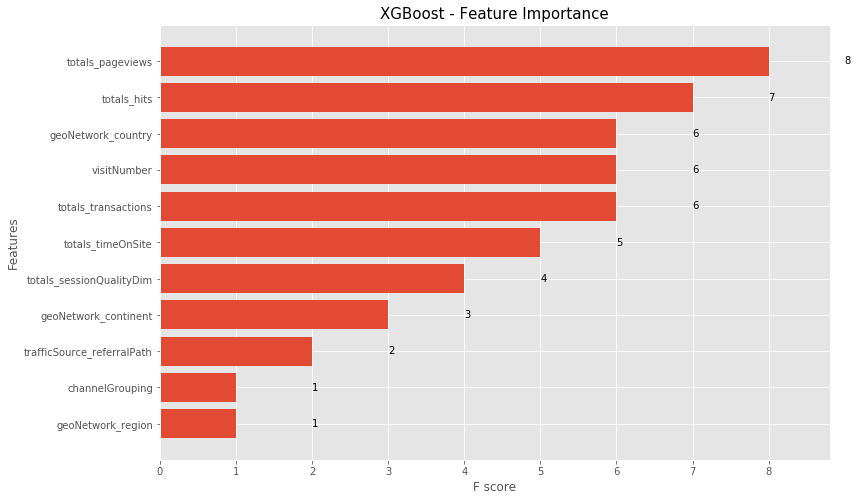

In [80]:

fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(xg_reg_random_grid, max_num_features=50, height=0.8, ax=ax)
ax.grid(True)
plt.title("XGBoost - Feature Importance", fontsize=15)
plt.show()

**Making predictions on Test set:**

In [81]:
test_predictions = pd.DataFrame(xg_reg_random_grid.predict(test_X))
test_predictions['fullVisitorId'] = test_fullVisitorId
test_predictions.columns = ['predicted_revenue','fullVisitorId']

In [82]:
test_predictions = test_predictions.groupby('fullVisitorId')['predicted_revenue'].sum().reset_index()

*Writing to csv*

In [83]:
test_predictions.to_csv('predictions')